In [1]:
import numpy as np 
from recoMRD import recoMRD
import matplotlib.pyplot as plt
from bart import bart

In [2]:
filename = './../example_data/meas_MID00159_FID03019_localizer_2D_iPAT2_interleaved.mrd'
mrd = recoMRD(filename)

mrd.img = mrd.kspace_to_image(mrd.kspace['image_scan'])
img_sos = mrd.remove_oversampling(mrd.img)
img_sos = mrd.coil_combination(img_sos, method='sos')

MRD file has more than one group. The last group will be imported.
Number of reference scans: 192
Number of image scans: 768
Acceleration factor: 2 x 1
Reference scan type: integrated
Existing scans: acs, noise, image_scan.


Filling image_scan, samples=44x384: 100%|██████████| 768/768 [00:00<00:00, 3117.15it/s]


Reorder slice... Done.


Fourier transform: 100%|██████████| 44/44 [00:00<00:00, 45.69it/s]


Remove oversampling... Done.


(192, 192, 8)


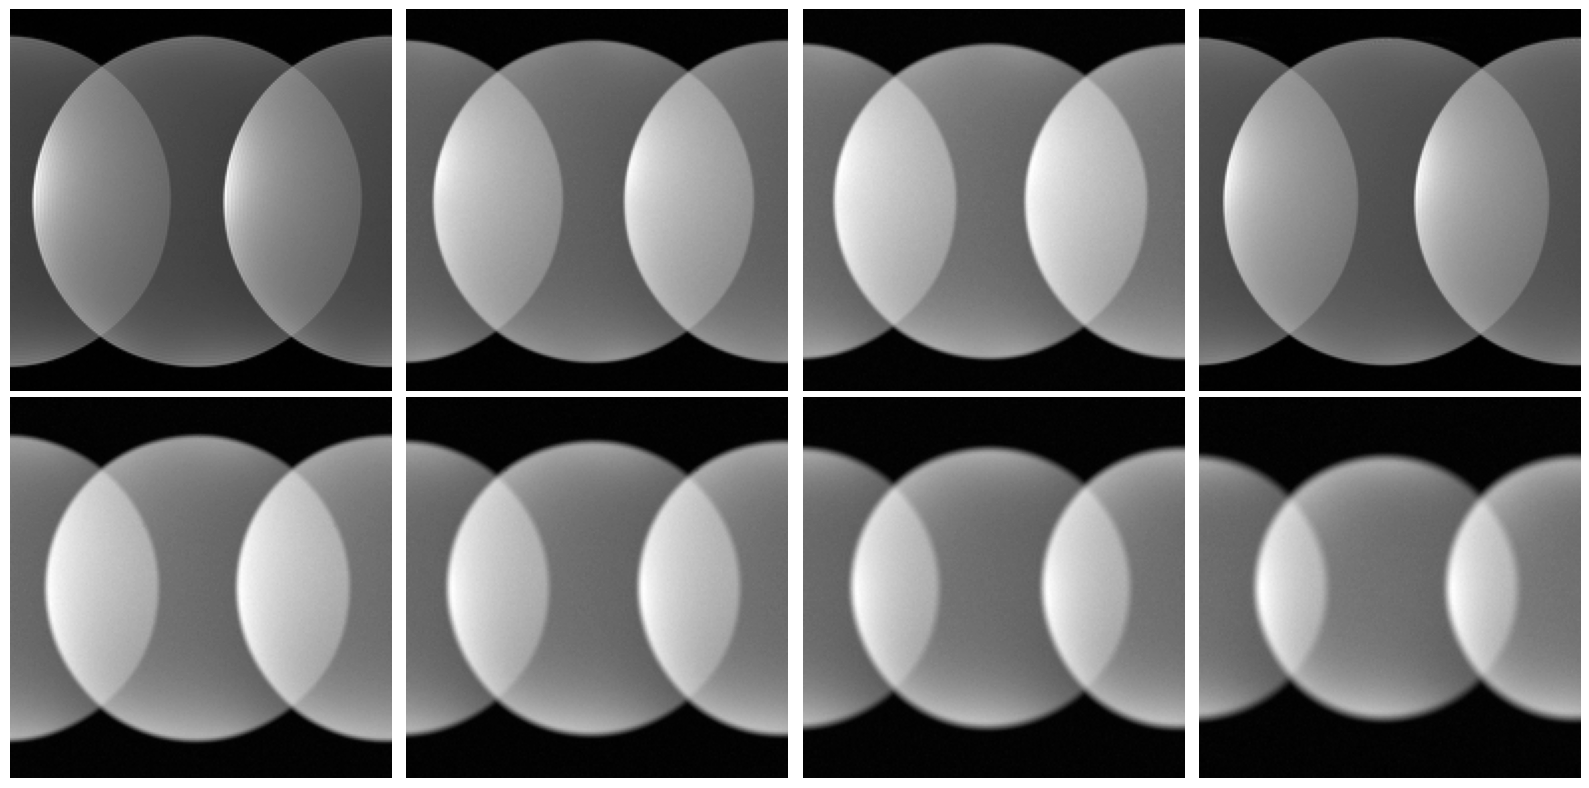

In [3]:
print(img_sos.squeeze().shape)
temp = img_sos.squeeze()
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[...,i*4+index]),cmap='gray')
        ax.set_axis_off()
plt.tight_layout()  

(384, 192, 8)


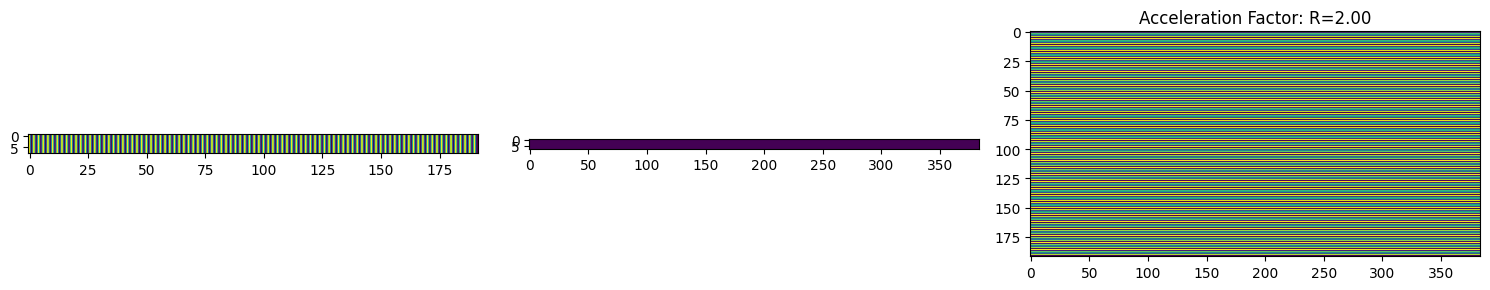

In [4]:
# show sampling pattern
temp = mrd.kspace['image_scan'].squeeze()[0,...]
mask = bart.bart(1, 'pattern', temp).real
print(mask.shape)
shp = [x // 2 for x in mask.shape]
R = np.prod(np.shape(mask)) / np.sum(mask) # acceleration factor
fig, axes = plt.subplots(1,3, figsize=(15, 5))
axes[0].imshow(np.abs(mask[shp[0],:,:]).T)
axes[1].imshow(np.abs(mask[:,shp[1],:]).T)
axes[2].imshow(np.abs(mask[:,:,shp[2]]).T)
plt.title('Acceleration Factor: R={:.2f}'.format(R))
plt.tight_layout()

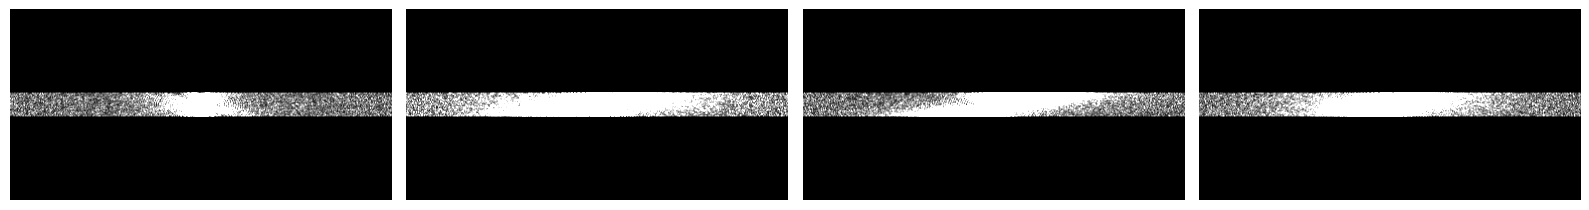

In [5]:
temp = mrd.kspace['acs'][::12,...].squeeze()
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axes[i].imshow(np.abs(temp[i,...,0]).T,cmap='gray', vmax=1e-5)
    axes[i].set_axis_off()
plt.tight_layout() 

Fourier transform: 100%|██████████| 44/44 [00:01<00:00, 42.00it/s]


Remove oversampling... Done.


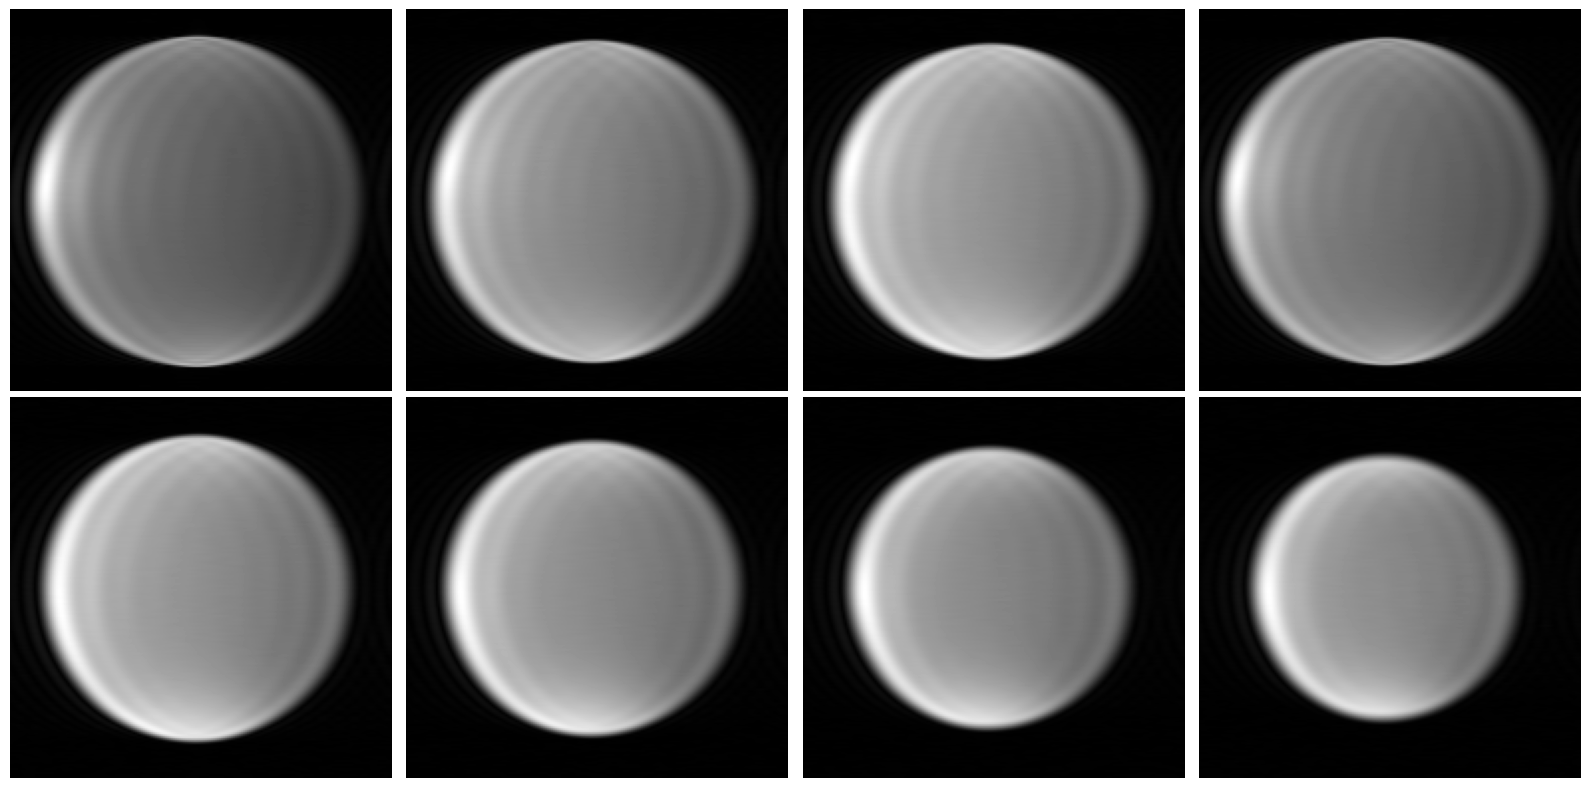

In [6]:
acs_img = mrd.kspace_to_image(mrd.kspace['acs'])
acs_img = mrd.remove_oversampling(acs_img)
acs_img = mrd.coil_combination(acs_img, method='sos')

temp = acs_img.squeeze()
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[...,i*4+index]),cmap='gray')
        ax.set_axis_off()
plt.tight_layout() 


In [7]:
%%time
coils_sensitivity = mrd.calc_coil_sensitivity(mrd.kspace['acs'], method='espirit')
print(coils_sensitivity.shape)

Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
(44, 384, 192, 1, 8)
CPU times: user 184 ms, sys: 236 ms, total: 420 ms
Wall time: 16.4 s


In [8]:
%%time
acs_img = mrd.kspace_to_image(mrd.kspace['acs'])
acs_img = mrd.remove_oversampling(acs_img)
acs_img = mrd.image_to_kspace(acs_img)
coils_sensitivity_os_removed = mrd.calc_coil_sensitivity(acs_img, method='espirit')
print(coils_sensitivity.shape)

Fourier transform: 100%|██████████| 44/44 [00:00<00:00, 53.09it/s]


Remove oversampling... Done.


Fourier transform: 100%|██████████| 44/44 [00:00<00:00, 128.59it/s]


Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
(44, 384, 192, 1, 8)
CPU times: user 1.51 s, sys: 237 ms, total: 1.75 s
Wall time: 13.3 s


In [9]:
%%time
coils_sensitivity_caldir = mrd.calc_coil_sensitivity(mrd.kspace['acs'], method='caldir')


Calibration region 192x24x1
Done.
Calibration region 192x24x1
Done.
Calibration region 192x24x1
Done.
Calibration region 192x24x1
Done.
Calibration region 192x24x1
Done.
Calibration region 192x24x1
Done.
Calibration region 192x24x1
Done.
Calibration region 192x24x1
Done.
CPU times: user 178 ms, sys: 298 ms, total: 476 ms
Wall time: 8.7 s


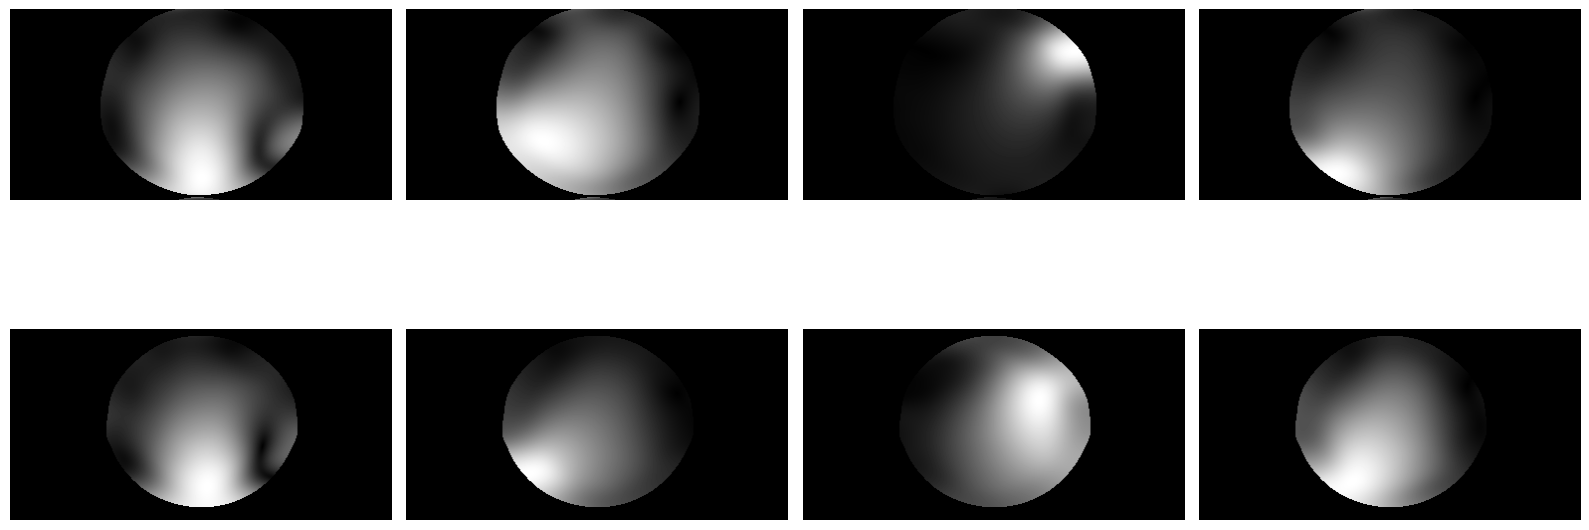

In [10]:
temp = coils_sensitivity[::12,...,::5].squeeze()
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[index,...,i].T),cmap='gray')
        ax.set_axis_off()
plt.tight_layout() 

Remove oversampling... Done.


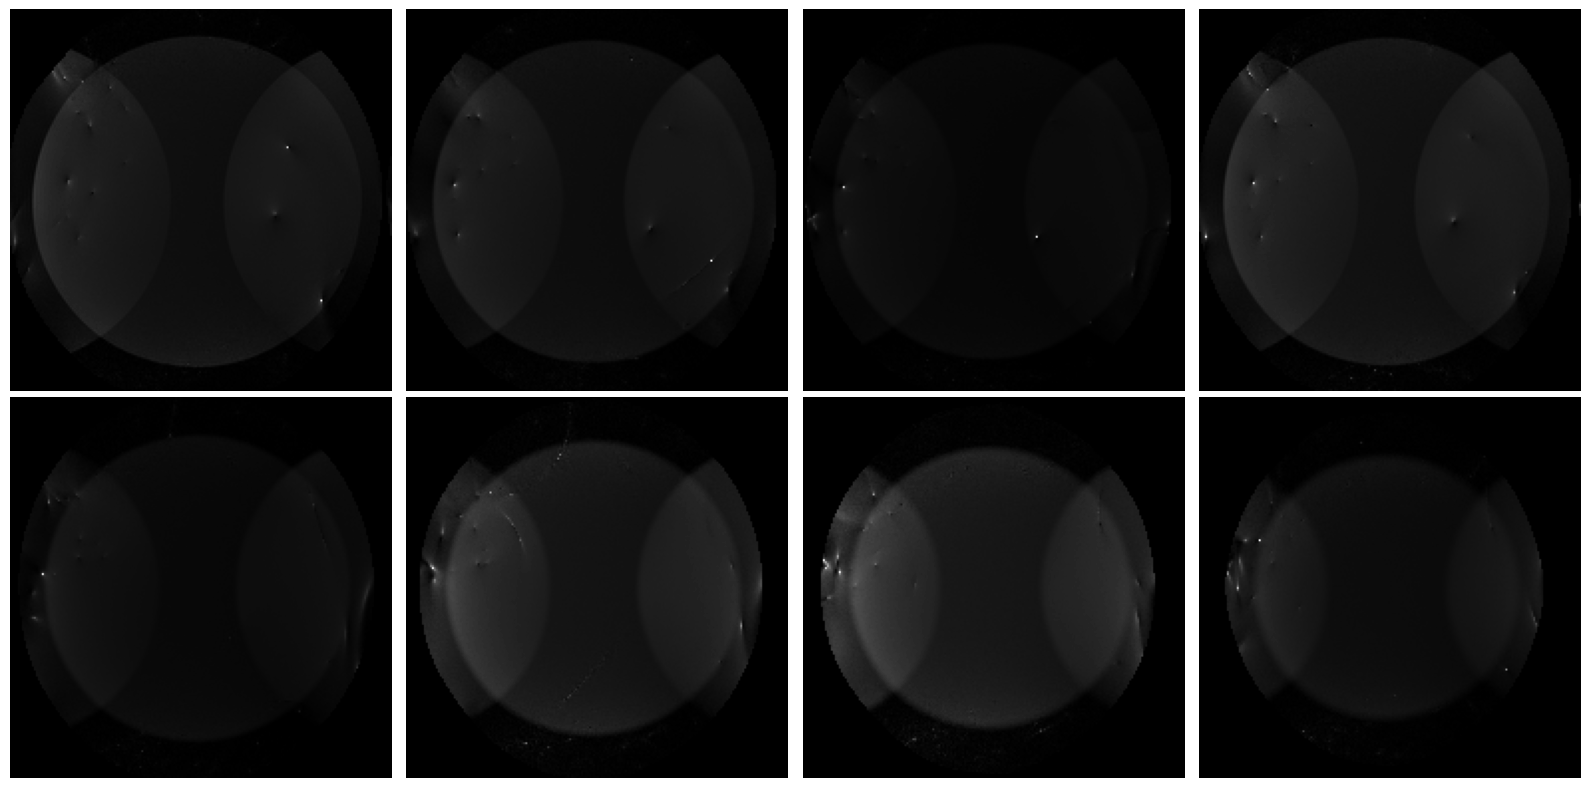

In [11]:
volume_comb = mrd.coil_combination(mrd.img, method='adaptive', coil_sens=coils_sensitivity)
volume_comb = mrd.remove_oversampling(volume_comb)

temp = volume_comb.squeeze()
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[:,:,i*4+index]),cmap='gray')
        ax.set_axis_off()
plt.tight_layout() 

In [12]:
%%time
volume_comb = mrd.coil_combination(mrd.kspace['image_scan'], method='bart', coil_sens=coils_sensitivity)
print(volume_comb.shape)

Size: 73728 Samples: 36864 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.981540
Size: 73728 Samples: 36864 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.929782
Size: 73728 Samples: 36864 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.892249
Size: 73728 Samples: 36864 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 1.111789
Size: 73728 Samples: 36864 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 0.986642
Size: 73728 Samples: 36864 Acc: 2.00
l2 regularization: 0.000100
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 1.282996
Size: 73728 Samples: 36864 Acc: 2.00
l2 regularization: 0.000100
Regul

Remove oversampling... Done.


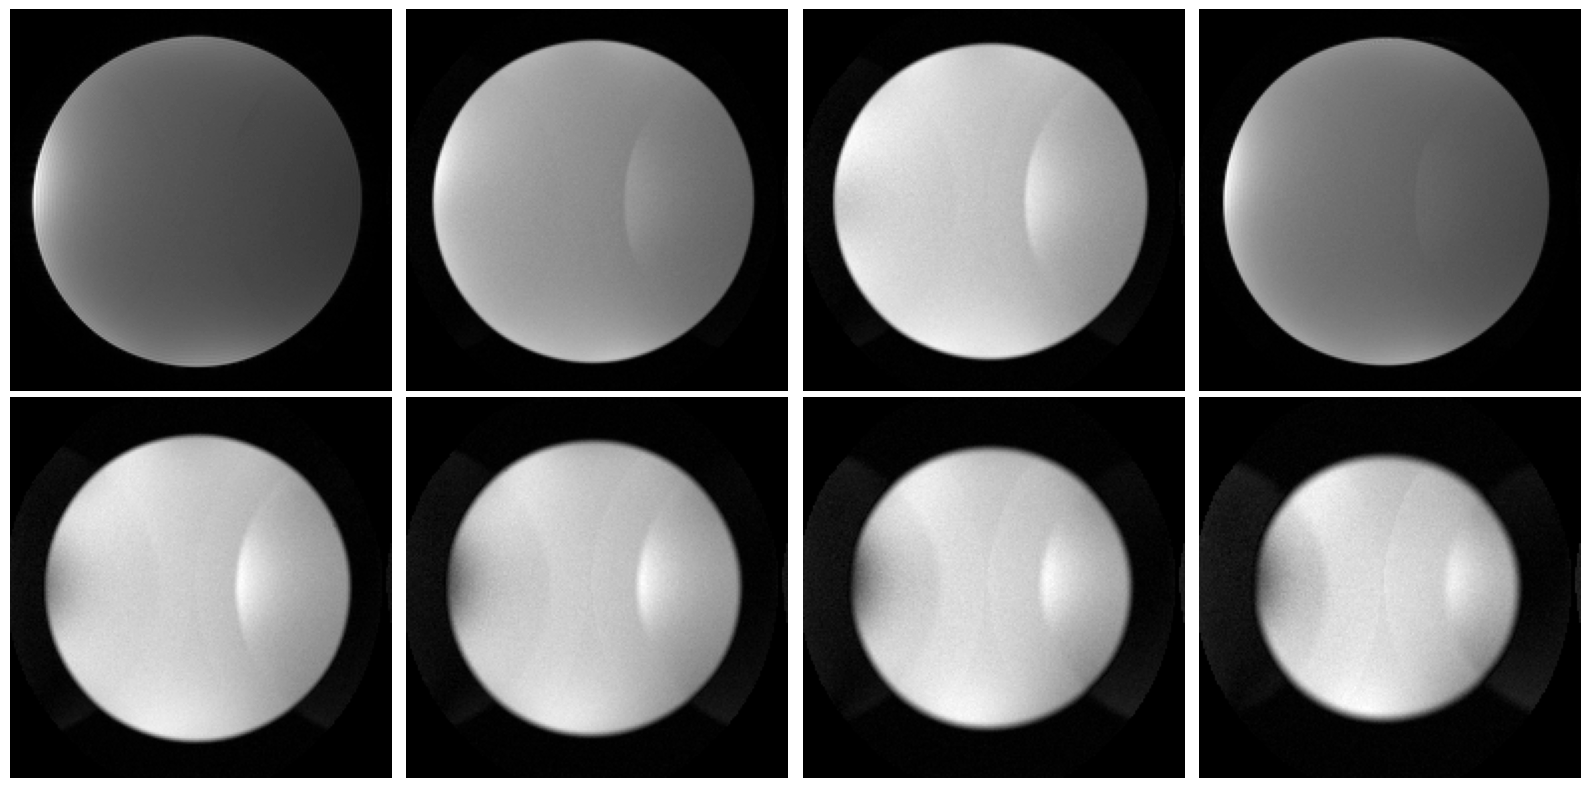

In [13]:
volume_comb = mrd.remove_oversampling(volume_comb)
temp = volume_comb.squeeze()
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(2):
    for ax, index in zip(axes[i], range(4)):
        ax.imshow(np.abs(temp[:,:,i*4+index]),cmap='gray')
        ax.set_axis_off()
plt.tight_layout() 